## SMS Spam classification 

**Data**: The data for this notebook comes from the SMS Spam Collection from kaggle. The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.
URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

**Methods**: In this notebook we will perform some data cleaning, along with some exploratory analysis of our data. We will then start modeling by setting two baseline machine learning models (Naive Bayes and SVM) and move towards deep learning models (RNNs: LSTM and GRU) to compare their performance on this text classification task.

In [3]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
from func_helpers import accuracy_metrics 
import tensorflow as tf 

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns 

ModuleNotFoundError: No module named 'wordcloud'

In [8]:
import sys
!{sys.executable} -m pip install pandas --upgrade --user

In [13]:
data = pd.read_csv(r'spam.csv', sep = ',', encoding="ISO-8859-1")
data.head() 

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [14]:
data.isna().sum() #Columns 2, 3 and 4 only contain NaNs

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

### Data cleaning: remove the 3 NaN columns and give proper column names to text and labels

In [15]:
data.dropna(how="any", inplace=True, axis=1)
data.columns = ['label', 'text']

In [16]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Exploratory analysis**: Target variable distribution

The ratio between ham and spam text is 6.46 to 1


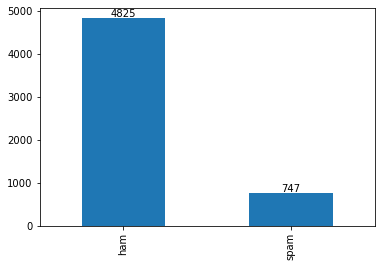

In [17]:
target_dist = data['label'].value_counts()
ax = target_dist.plot(kind = 'bar')
ax.bar_label(ax.containers[0])

print(f'The ratio between ham and spam text is {round(target_dist["ham"] / target_dist["spam"],2)} to 1')

The labels are slightly imbalanced, but regular classification techniques should still be enough!

Let's check the **word count distribution** between the two categories

Text(0.5, 0.98, 'Words distribution')

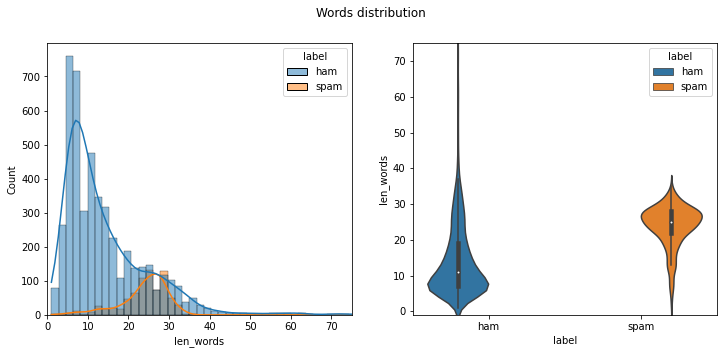

In [18]:
data['len_words'] = data['text'].apply(lambda x: len(x.split(' ')))

fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.histplot(data = data, x = 'len_words', hue = 'label', ax = ax[0], kde = True)
ax[0].set_xlim(0,75)
sns.violinplot(data = data,  x = 'label', y = 'len_words', hue = 'label', ax = ax[1])
ax[1].set_ylim(-1,75)
fig.suptitle('Words distribution')

Spam texts tend to have a length of 20-30 words, while regular texts are mostly shorter than 20 words. \
What if we also look at **character counts** rather than word counts for both groups?

Text(0.5, 0.98, 'Character lenght distribution ')

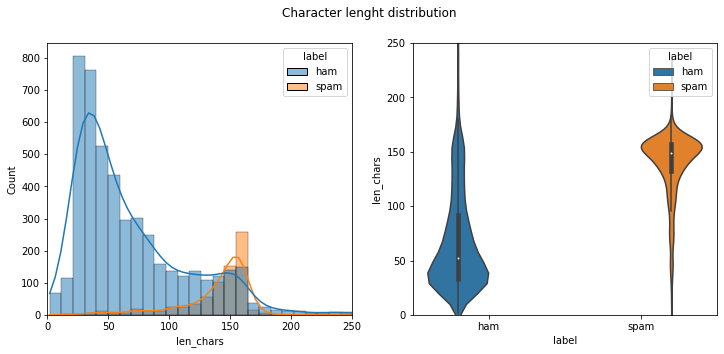

In [19]:
data['len_chars'] = data['text'].apply(lambda x: len(x))

fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.histplot(data = data, x = 'len_chars', hue = 'label', ax = ax[0], kde = True)
ax[0].set_xlim(0,250)
sns.violinplot(data = data,  x = 'label', y = 'len_chars', hue = 'label', ax = ax[1])
ax[1].set_ylim(0,250)
fig.suptitle('Character lenght distribution ')

We can see similar results to what we previously saw for words. \
Let's look at one more thing: most common words from the two different categories!

In [20]:
texts_spam = [obs['text'] for n,obs in data.loc[data['label']=='spam'].iterrows()]
texts_spam = ' '.join(texts_spam)
texts_ham = [obs['text'] for n,obs in data.loc[data['label']=='ham'].iterrows()]
texts_ham = ' '.join(texts_ham)

In [21]:
from wordcloud import WordCloud, ImageColorGenerator

fig, axs = plt.subplots(2,2,figsize = (15,10))
wordcloud_spam = WordCloud(max_words = 50).generate(texts_spam)
axs[0,0].imshow(wordcloud_spam, interpolation='bilinear')
axs[0,0].set_title('Most frequent Spam words')
axs[0,0].axis("off")

wordcloud_ham = WordCloud(max_words = 50).generate(texts_ham)
axs[0,1].imshow(wordcloud_ham, interpolation='bilinear')
axs[0,1].set_title('Most frequent Ham words')
axs[0,1].axis("off")

pd.Series(texts_spam.split(' ')).value_counts()[:20].plot.bar(ax = axs[1,0])
pd.Series(texts_ham.split(' ')).value_counts()[:20].plot.bar(ax = axs[1,1])
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

We can see how the most common words from both spam and ham are stop words. We might require some cleaning of the data before modeling. \
By looking at the least common words, we can see that we also have to remove punctuation and phone numbers / URL links! 

In [ ]:
pd.Series(texts_ham.split(' ')).value_counts()[-50:], pd.Series(texts_ham.split(' ')).value_counts()[-50:]

Thanks to all the previous insights, we can get started with..

# Data processing for modeling 

Let's start by removing stop words, punctuation, phone numbers and URLS as we just said! 

In [22]:
from nltk.corpus import stopwords
from string import punctuation 

sw = set(stopwords.words('english'))
punct = list(punctuation)
sw.update(punct)

def clean_data(txt):
    col = [i.strip() for i in txt.split()  if i.strip().lower() not in sw if i.strip().isalpha()]
    return ' '.join(col)

data['text'] = data['text'].apply(lambda x: clean_data(x))

Let's take a quick look at some rows and see if everything looks good!

In [23]:
for ind,row in data[:20].iterrows():
    print(row['text'])

Go jurong Available bugis n great world la e Cine got amore
Ok Joking wif u
Free entry wkly comp win FA Cup final tkts May Text FA receive entry txt apply
U dun say early U c already
Nah think goes lives around though
FreeMsg Hey darling word like fun Tb XxX std chgs rcv
Even brother like speak treat like aids
per request Melle Minnaminunginte Nurungu set callertune Press copy friends Callertune
valued network customer selected receivea prize claim call Claim code Valid hours
mobile months U R entitled Update latest colour mobiles camera Call Mobile Update Co FREE
gonna home soon want talk stuff anymore cried enough
SIX chances win pounds send Cost TsandCs apply Reply HL info
week FREE membership Prize Txt CLAIM LCCLTD POBOX
searching right words thank promise wont take help granted fulfil wonderful blessing
DATE SUNDAY
use click WAP link next txt message click
Oh watching
Eh u remember spell Yes v naughty make v
Fine thatåÕs way u ThatåÕs way gota b
England v Macedonia dont miss Txt u

As a last step before extracting features from our texts, I want to apply **lemmatization** to our tokens.

I'm not going to apply stemming (at least for now) as I am not the biggest fan of this technique and don't feel like this is a preprocessing needed for this task. Although stemming can often prove to be useful, there's plenty of examples where stemming can lead to the union of words with very different meanings just because they share a similar root, whereas with lemmatization these cases tend to be less frequent. \
For more information and some debate on stemming, I suggest to see this issue on SpaCy's github:  https://github.com/explosion/spaCy/issues/327  

For now, let's just stick with the WordNet Lemmatizer from the nltk library!

In [26]:
import nltk
from nltk.stem import WordNetLemmatizer 

def lemmatize_sentence(sentence):
    
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(sentence)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in words])
    
    return lemmatized_output

data['text'] = data['text'].apply(lambda x: lemmatize_sentence(x))

## Model baselines 
We will have two baseline model pipelines: tf-idf + Naive Bayes  and tf-idf + SVM.\
Naive Bayes and SVM used to be a staple of Machine Learning text classification, therefore we will use these two methods as a baseline and build up from there.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

X = data['text']
y = (data['label']=='spam').astype(int)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=.2, stratify = y)

results_dic = {} 
roc_dic = {}

In [28]:
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()
parameters = {'fit_prior':(True, False), 'alpha':np.linspace(0.1,1, 10)}

grid = GridSearchCV(nb, parameters)
grid.fit(X_train, y_train)

nb = BernoulliNB(**grid.best_params_)
nb.fit(X_train, y_train)
yhat = nb.predict(X_test)

print(grid.best_params_)

{'alpha': 0.1, 'fit_prior': True}


Accuracy: 0.9730941704035875 
weighted F1-score: 0.9732494079794761


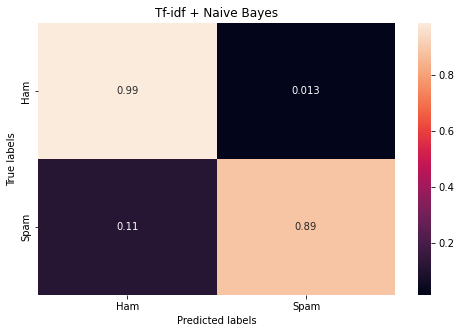

In [29]:
name = 'Tf-idf + Naive Bayes'
results_dic[name] = accuracy_metrics(y_test, yhat, name, mode = 'weighted')

In [30]:
from sklearn import svm 

sv = svm.SVC(probability=True)
parameters = {'kernel':('linear', 'rbf'), 'C':np.linspace(1,10,2)}

grid = GridSearchCV(sv, parameters)
grid.fit(X_train, y_train)

sv = svm.SVC(**grid.best_params_, probability=True)
sv.fit(X_train, y_train)
yhat = sv.predict(X_test)

print(grid.best_params_)

{'C': 1.0, 'kernel': 'linear'}


Accuracy: 0.9713004484304932 
weighted F1-score: 0.9723812922292463


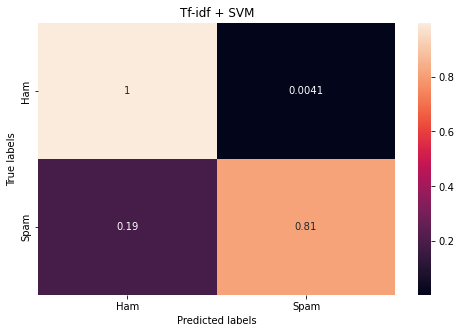

In [31]:
name = 'Tf-idf + SVM'
results_dic[name] = accuracy_metrics(y_test, yhat, name, mode = 'weighted')

The two baseline models already show some very good performance, with about **97.0% accuracy** and a **0.971% weighted f1-score**. I decided to use a weighted f1-score to account for the label class imbalance (we previously saw there was a 6.46 ratio between ham and spam labels)


The highest results on kaggle for this dataset, however, are a little higher (about 98-99%) thanks to the use of RNNs and Transformers. On this notebook, I will only focus on the former (LSTM and GRUs).

-----------

## LSTM model
In the following section I will use the tensorflow Sequential API to build a sequential LSTM model and train it on our data. 

I will split the Data as follows: 80% of data training set, 10% of data validation set, 10% of data test set

In [62]:
X_train, X_other, y_train, y_other = train_test_split(data['text'], y, random_state = 42, test_size=.2, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_other,y_other, test_size=0.5, stratify = y_other)

In [83]:
nwords = 2500
drop_rate = .2

encoder = tf.keras.layers.TextVectorization(max_tokens=nwords)
encoder.adapt(X_train)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=62, mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(drop_rate),   
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(drop_rate),   
    tf.keras.layers.Dense(1, activation='sigmoid')
])
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [84]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      optimizer=tf.keras.optimizers.Adam(.0001),
      metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid),epochs=10, batch_size=32) 

Epoch 1/10
140/140 [==============================] - 10s 40ms/step - loss: 0.7197 - accuracy: 0.6217 - val_loss: 0.6137 - val_accuracy: 0.8671
Epoch 2/10
140/140 [==============================] - 4s 32ms/step - loss: 0.5130 - accuracy: 0.7689 - val_loss: 0.5132 - val_accuracy: 0.8815
Epoch 3/10
140/140 [==============================] - 4s 32ms/step - loss: 0.3871 - accuracy: 0.8510 - val_loss: 0.3732 - val_accuracy: 0.9605
Epoch 4/10
140/140 [==============================] - 4s 32ms/step - loss: 0.2994 - accuracy: 0.9098 - val_loss: 0.2571 - val_accuracy: 0.9695
Epoch 5/10
140/140 [==============================] - 5s 32ms/step - loss: 0.2379 - accuracy: 0.9318 - val_loss: 0.1869 - val_accuracy: 0.9641
Epoch 6/10
140/140 [==============================] - 5s 32ms/step - loss: 0.1868 - accuracy: 0.9569 - val_loss: 0.1362 - val_accuracy: 0.9731
Epoch 7/10
140/140 [==============================] - 5s 33ms/step - loss: 0.1398 - accuracy: 0.9704 - val_loss: 0.1271 - val_accuracy: 0.973

Accuracy: 0.982078853046595 
weighted F1-score: 0.981647630145093


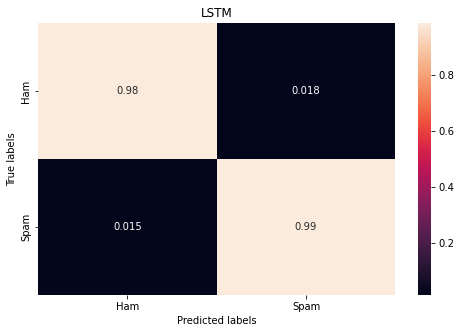

In [85]:
yhat = pd.Series((model.predict(X_test)>.5).reshape(-1)).astype(int)

name = 'LSTM'
results_dic[name] = accuracy_metrics( yhat, y_test, name)

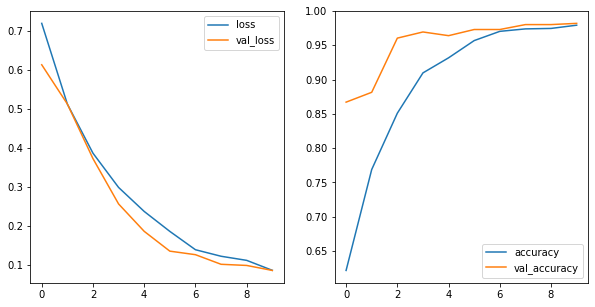

In [86]:
lstm_metrics = pd.DataFrame(history.history)

fig,axs = plt.subplots(1,2,figsize = (10,5))
lstm_metrics[['loss','val_loss']].plot(ax = axs[0])
lstm_metrics[['accuracy','val_accuracy']].plot(ax = axs[1])
plt.show()

### GRU model!  

Following a similar network structure, I will substitute the two LSTM layers with GRU layers and see if we notice differences in model performance! 

In [91]:
nwords = 2500
drop_rate = .2

encoder = tf.keras.layers.TextVectorization(max_tokens=nwords)
encoder.adapt(X_train)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=62, mask_zero=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(drop_rate),   
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(drop_rate),   
    tf.keras.layers.Dense(1, activation='sigmoid')
])
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [92]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      optimizer=tf.keras.optimizers.Adam(.0002),
      metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid),epochs=10, batch_size=32) 

Epoch 1/10
140/140 [==============================] - 9s 37ms/step - loss: 0.6754 - accuracy: 0.6177 - val_loss: 0.6234 - val_accuracy: 0.8671
Epoch 2/10
140/140 [==============================] - 4s 27ms/step - loss: 0.4461 - accuracy: 0.8070 - val_loss: 0.4988 - val_accuracy: 0.9138
Epoch 3/10
140/140 [==============================] - 4s 27ms/step - loss: 0.2938 - accuracy: 0.9042 - val_loss: 0.3246 - val_accuracy: 0.9641
Epoch 4/10
140/140 [==============================] - 4s 27ms/step - loss: 0.1924 - accuracy: 0.9502 - val_loss: 0.1990 - val_accuracy: 0.9731
Epoch 5/10
140/140 [==============================] - 4s 29ms/step - loss: 0.1320 - accuracy: 0.9684 - val_loss: 0.1125 - val_accuracy: 0.9767
Epoch 6/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0871 - accuracy: 0.9841 - val_loss: 0.0865 - val_accuracy: 0.9803
Epoch 7/10
140/140 [==============================] - 4s 28ms/step - loss: 0.0804 - accuracy: 0.9805 - val_loss: 0.0790 - val_accuracy: 0.9838

Accuracy: 0.978494623655914 
weighted F1-score: 0.9778367454861374


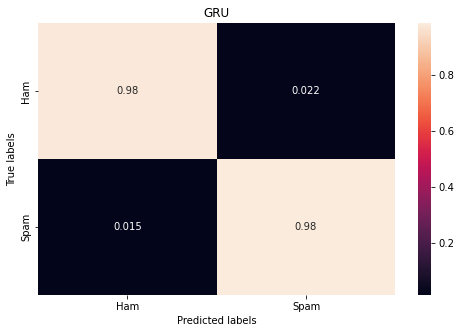

In [93]:
yhat = pd.Series((model.predict(X_test)>.5).reshape(-1)).astype(int)

name = 'GRU'
results_dic[name] = accuracy_metrics( yhat, y_test, name)

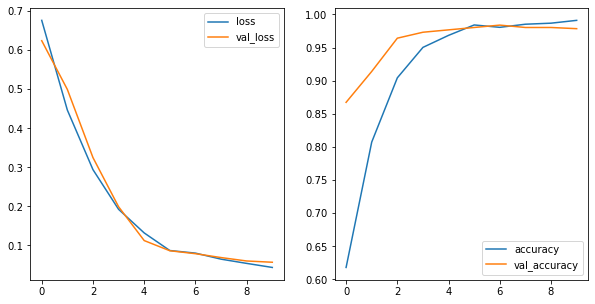

In [94]:
gru_metrics = pd.DataFrame(history.history)

fig,axs = plt.subplots(1,2,figsize = (10,5))
gru_metrics[['loss','val_loss']].plot(ax = axs[0])
gru_metrics[['accuracy','val_accuracy']].plot(ax = axs[1])
plt.show()

In [95]:
metrics = pd.DataFrame(results_dic, index = ['Accuracy', 'F1-score'])
metrics

,Tf-idf + Naive Bayes,Tf-idf + SVM,LSTM,GRU
Accuracy,0.973094,0.971300,0.982079,0.978495
F1-score,0.973249,0.972381,0.981648,0.977837


GRU and LSTM have shown great results so far, and perhaps we could improve a little more with some fine tuning of the model (e.g. by tweaking the amount of layers / neurons or by changing the optimizer or the learning rate). 

It would also be interesting to see if we could break into the 99% mark with BERT or other transformers, but all of this is outside of the scope of this notebook (maybe I could get back to this in the future and try these possibilities!)